# GRAFO

In [25]:
import pandas as pd
import networkx as nx
import joblib
import torch
import pandas as pd
import numpy as np
from collections import Counter
import itertools
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [ ]:
strict_fit = {
    "tight": ["straight", "tight", "complementos"],
    "straight": ["straight", "loose", "complementos"],
    "loose": ["straight", "loose", "oversize", "complementos"],
    "oversize": ["loose", "oversize", "complementos"],
    "complementos": ["tight", "straight", "loose", "oversize", "complementos"]
}

mapa_niveles = {
    'BOTTOM': 1, 'FULL': 1,          # Nivel 1: Piezas base
    'TOP_LIGHT': 2, 'TOP_HEAVY': 2,  # Nivel 2: Partes de arriba
    'OUTER': 3, 'ACC': 3, 'SHOES': 3 # Nivel 3: Abrigos y complementos
}

def categorizar_producto_niveles(title):
    t = str(title).lower()
    # NIVEL 3
    if any(x in t for x in ['jacket', 'coat', 'parka', 'blazer', 'trench', 'gilet', 'outer', 'jackect']): return 'OUTER'
    if any(x in t for x in ['bag', 'scarf', 'foulard', 'belt', 'hat']): return 'ACC'
    if any(x in t for x in ['shoe', 'boot', 'sneaker']): return 'SHOES'
    # NIVEL 2
    if any(x in t for x in ['sweater', 'knit', 'cardigan', 'hoodie', 'pullover']): return 'TOP_HEAVY'
    if any(x in t for x in ['t-shirt', 'tshirt', 'shirt', 'top', 'bodysuit']): return 'TOP_LIGHT'
    # NIVEL 1
    if any(x in t for x in ['pant', 'jean', 'trousers', 'skirt', 'short', 'falda']): return 'BOTTOM'
    if any(x in t for x in ['dress', 'jumpsuit', 'playsuit']): return 'FULL'
    return 'OTHER'

# 2. CARGA DE DATOS
df_nodes = pd.read_csv("datos_season9.csv")
df_colors = pd.read_csv("resultados_combinaciones_actualizado.csv")

# 3. PREPROCESAMIENTO
df_nodes['fit'] = df_nodes['fit'].fillna('complementos')
df_nodes['weather'] = df_nodes['weather'].replace({"cold_season": "cold", "warm_season": "warm"})

if 'indice' not in df_nodes.columns:
    df_nodes.insert(0, 'indice', range(len(df_nodes)))

# Categorización Granular
df_nodes['categoria_estricta'] = df_nodes['title'].apply(categorizar_producto_niveles)

# --- NORMALIZACIÓN DE COLOR (hex_norm) ---
df_nodes['hex_norm'] = df_nodes['hexadecimal'].apply(
    lambda x: '#' + str(x).strip().upper() if not str(x).startswith('#') else str(x).strip().upper()
)

# Carga de pares de colores validados
pares_color_ok = set()
df_colors['color_a'] = df_colors['color_a'].str.upper().str.strip()
df_colors['color_b'] = df_colors['color_b'].str.upper().str.strip()
for _, row in df_colors[df_colors['label'] == 1].iterrows():
    pares_color_ok.add(tuple(sorted((row['color_a'], row['color_b']))))

# 4. CREACIÓN DEL GRAFO
aristas = []
grupos = df_nodes.groupby(['season', 'application', 'weather'])

print("Creando el Grafo...")
for keys, grupo in grupos:
    items = grupo.to_dict('records')
    n = len(items)
    for i in range(n):
        for j in range(i + 1, n):
            u, v = items[i], items[j]
            cat1, cat2 = u['categoria_estricta'], v['categoria_estricta']
            lvl1, lvl2 = mapa_niveles.get(cat1, 0), mapa_niveles.get(cat2, 0)

            # REGLA 1: No pueden ir dos prendas de NIVEL 1 juntas (evita Pantalón + Vestido)
            if lvl1 == 1 and lvl2 == 1: continue
            
            # REGLA 2: Diferente categoría específica (evita Camiseta + Camiseta)
            if cat1 == cat2: continue

            # REGLA 3: Exclusión de solapamiento físico (FULL no con TOP ni BOTTOM)
            cuerpo_base = {'FULL', 'TOP_LIGHT', 'TOP_HEAVY', 'BOTTOM'}
            if cat1 in cuerpo_base and cat2 in cuerpo_base:
                if 'FULL' in [cat1, cat2]: continue 

            # REGLA 4: Atributos de Estilo y Atrevimiento
            if abs(u['adventurous'] - v['adventurous']) > 2: continue
            if u['style'] != v['style']: continue

            # REGLA 5: Colores Validados (Usando hex_norm)
            color_pair = tuple(sorted((u['hex_norm'], v['hex_norm'])))
            if color_pair not in pares_color_ok: continue

            # REGLA 6: Fit Estricto
            if v['fit'] not in strict_fit.get(u['fit'], []): continue

            aristas.append({
                'INDICE_1': u['indice'], 
                'INDICE_2': v['indice'],
                'Nombre_1': u['title'], 
                'Nombre_2': v['title'],
                'Lvl_1': lvl1,
                'Lvl_2': lvl2
            })

df_aristas = pd.DataFrame(aristas)
df_aristas.to_csv("aristas_grafo.csv", index=False)

G = nx.Graph()
for _, row in df_aristas.iterrows():
    G.add_edge(row['INDICE_1'], row['INDICE_2'])
joblib.dump(G, 'grafo_moda.pkl')

nodos_totales = set(range(len(df_nodes)))
nodos_conectados = set(G.nodes())
nodos_aislados = sorted(list(nodos_totales - nodos_conectados))
total_triangulos = sum(nx.triangles(G).values()) // 3

print("\n" + "="*40)
print("RESULTADOS DEL GRAFO")
print("="*40)
print(f"Número de Aristas: {len(df_aristas)}")
print(f"Nodos Aislados: {len(nodos_aislados)}")
print(f"Total de Looks de 3 (Triángulos): {total_triangulos}")
print("-" * 40)

Creando el Grafo...

RESULTADOS DEL GRAFO
Número de Aristas: 36876
Nodos Aislados: 27
Total de Looks de 3 (Triángulos): 337823
----------------------------------------


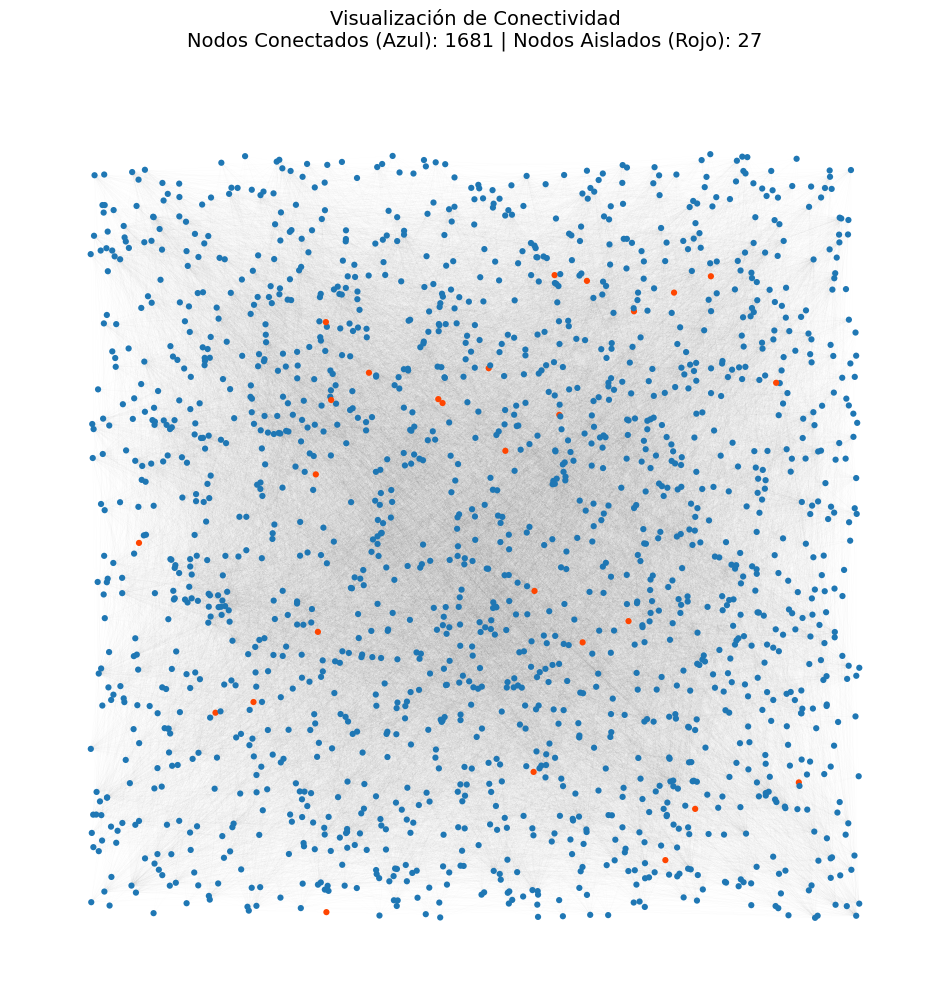

In [46]:
df_edges2= pd.read_csv("aristas_grafo.csv")

if 'indice' not in df_nodes.columns:
    df_nodes.insert(0, 'indice', range(len(df_nodes)))

G = nx.Graph()

# --- PASO CLAVE ---
# Añadimos TODOS los nodos del dataframe. Esto permite que existan nodos con "grado 0"
G.add_nodes_from(df_nodes['indice'])

# Añadimos las aristas desde el CSV
edges = list(zip(df_edges2['INDICE_1'], df_edges2['INDICE_2']))
G.add_edges_from(edges)

COLOR_CONECTADO = '#1f77b4' # Azul
COLOR_AISLADO = '#FF4500'   # Rojo

colores_finales = []
for n in G.nodes():
    # G.degree(n) devuelve el número de conexiones del nodo
    if G.degree(n) > 0:
        colores_finales.append(COLOR_CONECTADO)
    else:
        colores_finales.append(COLOR_AISLADO)

plt.figure(figsize=(12, 12), facecolor='white')
ax = plt.gca()
pos = nx.random_layout(G)
# ARISTAS
nx.draw_networkx_edges(
    G, pos, 
    alpha=0.03, 
    edge_color='black', 
    width=0.1
)

# NODOS
nx.draw_networkx_nodes(
    G, pos, 
    node_size=20, 
    node_color=colores_finales, 
    alpha=1.0,
    linewidths=0
)

n_aislados = len([n for n in G.nodes() if G.degree(n) == 0])
n_conectados = len(G.nodes()) - n_aislados
plt.title(f"Visualización de Conectividad\nNodos Conectados (Azul): {n_conectados} | Nodos Aislados (Rojo): {n_aislados}", 
          fontsize=14, pad=20)
plt.axis('off')
plt.show()

In [51]:
cat_map = df_nodes.set_index('indice')['categoria_estricta'].to_dict()

conteos_combinaciones = Counter()

# 2. Buscamos triángulos de forma más eficiente
# En lugar de buscar todos los cliques, iteramos sobre las aristas
for u, v in G.edges():
    # Buscamos vecinos comunes entre el nodo u y el nodo v
    vecinos_comunes = set(G[u]) & set(G[v])
    for w in vecinos_comunes:
        # Usamos orden para no contar el mismo triángulo 3 veces
        if u < v < w:
            cats = tuple(sorted([cat_map[u], cat_map[v], cat_map[w]]))
            conteos_combinaciones[cats] += 1

df_conteo = pd.DataFrame([(list(k), v) for k, v in conteos_combinaciones.items()], columns=['Combinación', 'Cantidad'])
df_conteo = df_conteo.sort_values(by='Cantidad', ascending=False)

print("RESULTADO DE COMBINACIONES")
print("="*40)
print(df_conteo.to_string(index=False))

RESULTADO DE COMBINACIONES
                   Combinación  Cantidad
      [ACC, BOTTOM, TOP_LIGHT]     62719
[BOTTOM, TOP_HEAVY, TOP_LIGHT]     42857
    [BOTTOM, OUTER, TOP_LIGHT]     36522
   [ACC, TOP_HEAVY, TOP_LIGHT]     21104
 [OUTER, TOP_HEAVY, TOP_LIGHT]     18158
       [ACC, OUTER, TOP_LIGHT]     14418
          [ACC, BOTTOM, OUTER]     10995
      [ACC, BOTTOM, TOP_HEAVY]      8064
    [BOTTOM, OUTER, TOP_HEAVY]      7899
            [ACC, FULL, OUTER]      5253
       [ACC, OUTER, TOP_HEAVY]      2825
     [OTHER, OUTER, TOP_HEAVY]        10


In [33]:
(27/1709) * 100

1.579871269748391

Calculando Top Looks basados en popularidad (Grado)...


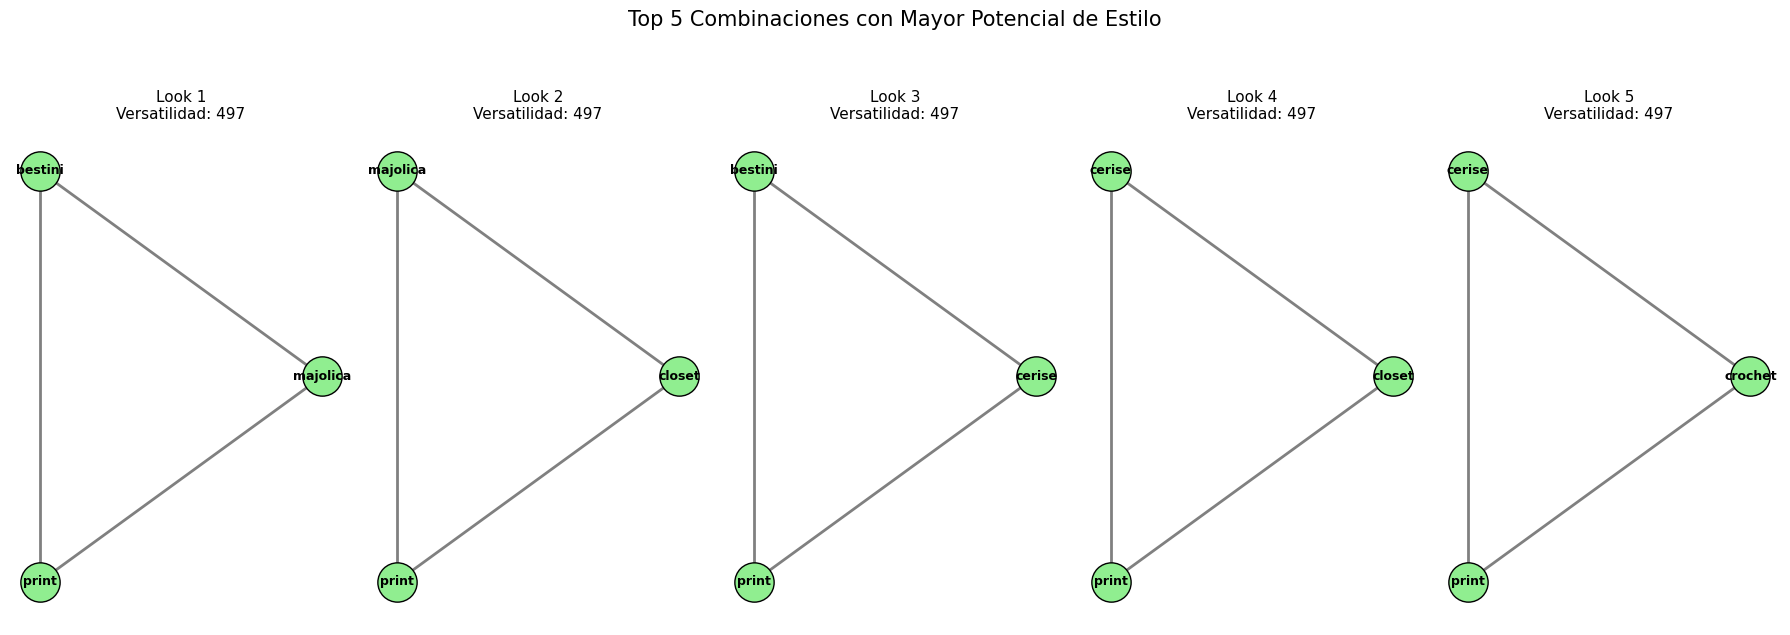

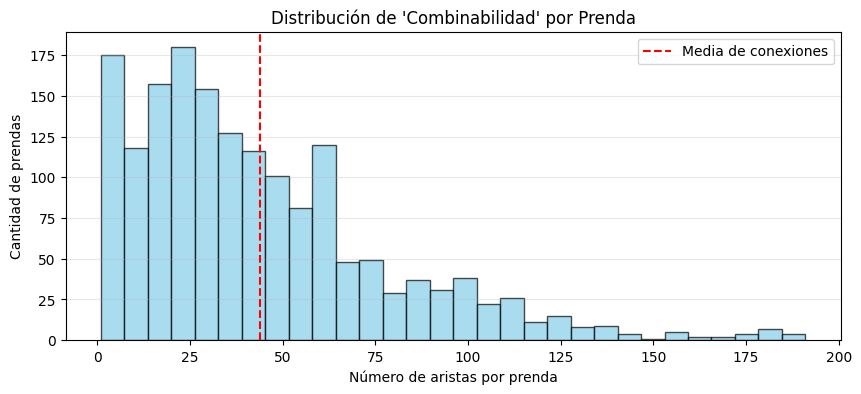

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import joblib
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import joblib
import heapq

# 1. CARGA DE DATOS
G = joblib.load('grafo_moda.pkl')
df_nodes2 = pd.read_csv("season9_limpios.csv")

nombres = dict(zip(df_nodes['indice'], df_nodes['title']))

print("Calculando Top Looks basados en popularidad (Grado)...")
top_n = 5
top_heap = []

# Pre-calculamos los grados para mayor velocidad
grados_dict = dict(G.degree())

# Algoritmo de intersección rápida para encontrar triángulos
nodes_list = sorted(G.nodes())
for i, u in enumerate(nodes_list):
    u_neighbors = set(G.neighbors(u))
    for v in [n for n in u_neighbors if n > u]:
        v_neighbors = set(G.neighbors(v))
        common = u_neighbors.intersection(v_neighbors)
        
        for k in [n for n in common if n > v]:
            # Calculamos el peso como la suma de conexiones de los 3 nodos
            # Esto premia looks con prendas muy combinables
            peso = grados_dict[u] + grados_dict[v] + grados_dict[k]
            
            if len(top_heap) < top_n:
                heapq.heappush(top_heap, (peso, (u, v, k)))
            elif peso > top_heap[0][0]:
                heapq.heappushpop(top_heap, (peso, (u, v, k)))

# Ordenar los mejores looks
top_looks = sorted(top_heap, reverse=True)

# 2. VISUALIZACIÓN DE LOS TOP LOOKS
plt.figure(figsize=(18, 6), facecolor='white')
for i, (peso, nodes) in enumerate(top_looks):
    plt.subplot(1, 5, i+1)
    sub = G.subgraph(nodes)
    pos = nx.circular_layout(sub)
    
    # Dibujar nodos
    nx.draw_networkx_nodes(sub, pos, node_color='lightgreen', node_size=800, edgecolors='black')
    nx.draw_networkx_edges(sub, pos, width=2, edge_color='gray')
    
    # Etiquetas con los nombres de las prendas
    labels = {n: nombres.get(n, n).split()[-1] for n in nodes} # Solo la última palabra para brevedad
    nx.draw_networkx_labels(sub, pos, labels=labels, font_size=9, font_weight='bold')
    
    plt.title(f"Look {i+1}\nVersatilidad: {peso}", fontsize=11)
    plt.axis('off')

plt.suptitle("Top 5 Combinaciones con Mayor Potencial de Estilo", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

# 3. HISTOGRAMA DE CONEXIONES
grados = list(grados_dict.values())
plt.figure(figsize=(10, 4))
plt.hist(grados, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(sum(grados)/len(grados), color='red', linestyle='dashed', label='Media de conexiones')
plt.title("Distribución de 'Combinabilidad' por Prenda")
plt.xlabel("Número de aristas por prenda")
plt.ylabel("Cantidad de prendas")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
mejor_look = top_looks[0]
score_max = mejor_look[0]
nodos_id = mejor_look[1]

print(f"--- ANALISIS DEL LOOK TOP (Versatilidad: {score_max}) ---")
for nid in nodos_id:
    detalle = df_nodes[df_nodes['indice'] == nid].iloc[0]
    print(f"ID: {nid} | Prenda: {detalle['title']} | Categoria: {detalle['categoria_estricta']} | Estilo: {detalle['style']}")

--- ANALISIS DEL LOOK TOP (Versatilidad: 497) ---
ID: 1254 | Prenda: Majo Jacket print  | Categoria: OUTER | Estilo: boho
ID: 1692 | Prenda: Ferial Top majolica | Categoria: TOP_LIGHT | Estilo: boho
ID: 1701 | Prenda: Noelia Bag bestini  | Categoria: ACC | Estilo: boho


In [50]:
grados = [d for n, d in G.degree()]
avg_degree = np.mean(grados)
max_degree = np.max(grados)

# 2. Densidad del grafo
density = nx.density(G)

# 3. Triángulos
total_triangulos = sum(nx.triangles(G).values()) // 3

print(f"--- DIAGNÓSTICO DEL GRAFO ---")
print(f"Grado Máximo: {max_degree}")
print(f"Grado Promedio: {avg_degree:.2f}")
print(f"Densidad: {density:.5f}")
print(f"Total Looks (Triángulos): {total_triangulos}")

--- DIAGNÓSTICO DEL GRAFO ---
Grado Máximo: 191
Grado Promedio: 43.87
Densidad: 0.02612
Total Looks (Triángulos): 337823


# PRENDAS QUE MAS COMBINAN?

In [52]:
# 1. Calculamos el grado (número de conexiones directas)
grados = dict(G.degree())

# 2. Calculamos los triángulos por cada nodo (participación en looks de 3)
triangulos_nodos = nx.triangles(G)

# 3. Añadimos los resultados a df_nodes
df_nodes['total_conexiones'] = df_nodes['indice'].map(grados).fillna(0).astype(int)
df_nodes['participacion_outfits'] = df_nodes['indice'].map(triangulos_nodos).fillna(0).astype(int)

# 4. Ranking de las 10 prendas más versátiles
top_versatiles = df_nodes.sort_values(by='total_conexiones', ascending=False).head(10)

print("\n" + "="*60)
print("RANKING DE VERSATILIDAD: LAS 10 PRENDAS MÁS COMBINABLES")
print("="*60)
print(top_versatiles[['title', 'categoria_estricta', 'style', 'total_conexiones', 'participacion_outfits']])
print("-" * 60)


RANKING DE VERSATILIDAD: LAS 10 PRENDAS MÁS COMBINABLES
                                 title categoria_estricta style  \
1254                Majo Jacket print               OUTER  boho   
1701               Noelia Bag bestini                 ACC  boho   
1482              Bristol Bag crochet                 ACC  boho   
1633                Roches Bag closet                 ACC  boho   
1653               Belvoir Bag closet                 ACC  boho   
1561                 Lurex Scarf gold                 ACC  boho   
1679               Noelia Bag bestini                 ACC  boho   
1637  Emirate Scarf sew T. UNQ C. ecru                ACC  boho   
1695              Exet Foulard closet                 ACC  boho   
1665                Roches Bag closet                 ACC  boho   

      total_conexiones  participacion_outfits  
1254               191                   6180  
1701               187                   4427  
1482               187                   4427  
1633         

In [53]:
print("\nLÍDERES DE COMBINACIÓN POR CATEGORÍA:")
categorias = df_nodes['categoria_estricta'].unique()

for cat in categorias:
    if cat == 'OTHER': continue
    subset = df_nodes[df_nodes['categoria_estricta'] == cat]
    if not subset.empty:
        lider = subset.loc[subset['total_conexiones'].idxmax()]
        print(f"- [{cat}]: {lider['title']} | Conexiones: {lider['total_conexiones']}")


LÍDERES DE COMBINACIÓN POR CATEGORÍA:
- [OUTER]: Majo Jacket print  | Conexiones: 191
- [TOP_LIGHT]: Dotts Shirt cerise  | Conexiones: 119
- [BOTTOM]: Neola Skirt twill  | Conexiones: 119
- [TOP_HEAVY]: Shbasatin Cardigan knit | Conexiones: 143
- [ACC]: Bristol Bag crochet  | Conexiones: 187
- [FULL]: Icmarrakech Dress miniprint  | Conexiones: 47


In [42]:
df_nodes['style'].value_counts()

style
boho       515
classic    492
casual     322
street     275
minimal     53
night       51
Name: count, dtype: int64

In [54]:
# Prendas con muy pocas conexiones (pero al menos una)
dificiles = df_nodes[df_nodes['total_conexiones'].between(1, 2)].head(5)
print("\nPRENDAS CON POCAS CONEXIONES (Difíciles de combinar):")
print(dificiles[['title', 'style', 'categoria_estricta', 'total_conexiones']])


PRENDAS CON POCAS CONEXIONES (Difíciles de combinar):
                        title    style categoria_estricta  total_conexiones
23   Bynonina Cardigan pocket  minimal          TOP_HEAVY                 2
25       Viril Cardigan knit    casual          TOP_HEAVY                 2
150     Ihalpa Cardigan aqua   minimal          TOP_HEAVY                 1
191         Null Jeans toxik    street             BOTTOM                 1
218     Ihalpa Cardigan aqua   minimal          TOP_HEAVY                 1


## GNN (RED RECURRENTE)

In [55]:
# 1. PREPROCESAMIENTO DE DATOS
le_style, le_fit, le_cat, le_color = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()

df_nodes['style_enc'] = le_style.fit_transform(df_nodes['style'])
df_nodes['fit_enc'] = le_fit.fit_transform(df_nodes['fit'])
df_nodes['cat_enc'] = le_cat.fit_transform(df_nodes['categoria_estricta'])
df_nodes['hex_norm'] = df_nodes['hexadecimal'].apply(lambda x: str(x).upper().strip() if str(x).startswith('#') else '#' + str(x).upper().strip())
df_nodes['color_enc'] = le_color.fit_transform(df_nodes['hex_norm'])

# Features: [Style, Fit, Cat, Color, Adventurous]
features = ['style_enc', 'fit_enc', 'cat_enc', 'color_enc', 'adventurous']
x = torch.tensor(df_nodes[features].values, dtype=torch.float)

# Creación de aristas
edge_index = torch.tensor([df_aristas['INDICE_1'].values, 
                            df_aristas['INDICE_2'].values], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

# Split de datos (Link Prediction)
transform = T.RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)

In [58]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

class RedLookiero(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='GCN'):
        super().__init__()
        self.model_type = model_type
        
        # Capas Lineales para Skip Connections
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
        
        if model_type == 'GCN':
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
        elif model_type == 'GAT':
            self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=False)
            self.conv2 = GATConv(hidden_channels, out_channels, heads=4, concat=False)
        elif model_type == 'SAGE':
            self.conv1 = SAGEConv(in_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        h1 = self.conv1(x, edge_index).relu()
        h1 = h1 + self.lin1(x) 
        h2 = self.conv2(h1, edge_index)
        z = h2 + self.lin2(h1)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

def train_iteration(params, train_d, val_d):
    model = RedLookiero(
        train_d.num_features, 
        params['hidden_channels'], 
        params['out_channels'],
        model_type=params['model_type']
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.BCEWithLogitsLoss()
    
    best_auc = 0
    final_loss = 0
    
    for epoch in range(1, 301):
        model.train()
        optimizer.zero_grad()
        z = model.encode(train_d.x, train_d.edge_index)
        out = model.decode(z, train_d.edge_label_index)
        loss = criterion(out, train_d.edge_label)
        loss.backward()
        optimizer.step()
        
        final_loss = loss.item()
        
        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                z_v = model.encode(val_d.x, val_d.edge_index)
                v_out = model.decode(z_v, val_d.edge_label_index).sigmoid()
                auc = roc_auc_score(val_d.edge_label.cpu().numpy(), v_out.cpu().numpy())
                if auc > best_auc: 
                    best_auc = auc
            
    return best_auc, final_loss, model

# OPTIMIZACION DE HIPERPARAMETROS
param_grid = {
    'model_type': ['GCN', 'GAT', 'SAGE'],
    'hidden_channels': [128, 256],    
    'out_channels': [64, 128],      
    'lr': [0.01, 0.001],
    'weight_decay': [5e-4, 1e-4]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Iniciando búsqueda en {len(combinations)} combinaciones...")
resultados_log = []
best_overall_auc = 0
best_overall_params = None
best_model_state = None

for p in combinations:
    auc, loss, model_trained = train_iteration(p, train_data, val_data)
    
    # Guardar resultado de la combinación
    registro = p.copy()
    registro['best_auc_val'] = round(auc, 4)
    registro['final_loss_train'] = round(loss, 4)
    resultados_log.append(registro)
    
    print(f"Modelo: {p['model_type']} | AUC: {auc:.4f} | Loss: {loss:.4f}")
    
    if auc > best_overall_auc:
        best_overall_auc = auc
        best_overall_params = p
        best_model_state = model_trained.state_dict()

df_resultados = pd.DataFrame(resultados_log)
df_resultados.to_csv("resultados_gnn_hiperparametros.csv", index=False)
print("\n")
print(f"Mejor AUC: {best_overall_auc:.4f}")
print(f"Mejor configuracion: {best_overall_params}")
print("Resultados guardados en: resultados_gnn_hiperparametros.csv")

torch.save({'model_state_dict': best_model_state,'params': best_overall_params,'features': features}, 'mejor_modelo_gnn_entreno.pth')

Iniciando búsqueda en 48 combinaciones...
Modelo: GCN | AUC: 0.9004 | Loss: 0.5226
Modelo: GCN | AUC: 0.8820 | Loss: 0.5470
Modelo: GCN | AUC: 0.7658 | Loss: 0.9275
Modelo: GCN | AUC: 0.7670 | Loss: 0.9814
Modelo: GCN | AUC: 0.8681 | Loss: 0.5763
Modelo: GCN | AUC: 0.8479 | Loss: 0.6017
Modelo: GCN | AUC: 0.7694 | Loss: 1.1194
Modelo: GCN | AUC: 0.7649 | Loss: 1.2967
Modelo: GCN | AUC: 0.8750 | Loss: 0.5600
Modelo: GCN | AUC: 0.8575 | Loss: 0.5683
Modelo: GCN | AUC: 0.8196 | Loss: 0.6541
Modelo: GCN | AUC: 0.8027 | Loss: 0.7507
Modelo: GCN | AUC: 0.8350 | Loss: 0.6179
Modelo: GCN | AUC: 0.8490 | Loss: 0.6167
Modelo: GCN | AUC: 0.7869 | Loss: 0.8931
Modelo: GCN | AUC: 0.7842 | Loss: 0.8972
Modelo: GAT | AUC: 0.8300 | Loss: 0.6663
Modelo: GAT | AUC: 0.8599 | Loss: 0.6991
Modelo: GAT | AUC: 0.8483 | Loss: 0.5807
Modelo: GAT | AUC: 0.7764 | Loss: 0.6637
Modelo: GAT | AUC: 0.8346 | Loss: 0.6525
Modelo: GAT | AUC: 0.8843 | Loss: 0.5455
Modelo: GAT | AUC: 0.7992 | Loss: 0.7394
Modelo: GAT | A

In [ ]:
def evaluate_model(model, data_eval):
    model.eval()
    with torch.no_grad():
        z = model.encode(data_eval.x, data_eval.edge_index)
        # Obtenemos predicciones y aplicamos sigmoide para probabilidad
        out = model.decode(z, data_eval.edge_label_index).sigmoid()
        return roc_auc_score(data_eval.edge_label.cpu().numpy(), out.cpu().numpy())

model_final = RedLookiero(
    in_channels=train_data.num_features,
    hidden_channels=best_overall_params['hidden_channels'],
    out_channels=best_overall_params['out_channels'],
    model_type=best_overall_params['model_type']
)

optimizer = torch.optim.Adam(
    model_final.parameters(), 
    lr=best_overall_params['lr'], 
    weight_decay=best_overall_params['weight_decay']
)
criterion = torch.nn.BCEWithLogitsLoss()

history = []
for epoch in range(1, 2001):
    model_final.train()
    optimizer.zero_grad()
    
    z = model_final.encode(train_data.x, train_data.edge_index)
    out = model_final.decode(z, train_data.edge_label_index)
    loss = criterion(out, train_data.edge_label)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        auc_v = evaluate_model(model_final, val_data)
        history.append({'epoch': epoch, 'loss': loss.item(), 'auc': auc_v})
        print(f"Época {epoch:03d} | Loss: {loss:.4f} | AUC Val: {auc_v:.4f}")

def obtener_analisis_combinaciones(nueva_prenda, n_top=5, n_bottom=5):
    model_final.eval()

    cat_nueva = categorizar_producto_niveles(nueva_prenda['title'])
    lvl_nueva = mapa_niveles.get(cat_nueva, 0)
    color_nueva = nueva_prenda['hexadecimal'].upper().strip()
    if not color_nueva.startswith('#'): color_nueva = '#' + color_nueva

    x_nueva = torch.tensor([[
        le_style.transform([nueva_prenda['style']])[0],
        le_fit.transform([nueva_prenda['fit']])[0],
        le_cat.transform([cat_nueva])[0],
        le_color.transform([color_nueva])[0],
        nueva_prenda['adventurous']
    ]], dtype=torch.float)

    with torch.no_grad():
        z_catalog = model_final.encode(data.x, data.edge_index)
        z_nueva = model_final.encode(x_nueva, torch.empty((2, 0), dtype=torch.long))
        scores = (z_nueva @ z_catalog.t()).squeeze(0).sigmoid()
    
    indices_sorted = torch.argsort(scores, descending=True).tolist()
    top_ranking = []
    cuerpo_base = {'FULL', 'TOP_LIGHT', 'TOP_HEAVY', 'BOTTOM'}

    for idx in indices_sorted:
        item = df_nodes.iloc[idx]
        cat_item = item['categoria_estricta']
        lvl_item = mapa_niveles.get(cat_item, 0)

        # REGLAS DEL GRAFO
        if lvl_nueva == 1 and lvl_item == 1: continue
        if cat_item == cat_nueva: continue
        if cat_nueva in cuerpo_base and cat_item in cuerpo_base:
            if 'FULL' in [cat_nueva, cat_item]: continue
        if abs(nueva_prenda['adventurous'] - item['adventurous']) > 2: continue
        if nueva_prenda['style'] != item['style']: continue
        if item['fit'] not in strict_fit.get(nueva_prenda['fit'], []): continue
        
        color_pair = tuple(sorted((color_nueva, item['hex_norm'])))
        if color_pair not in pares_color_ok: continue

        top_ranking.append({
            'title': item['title'], 
            'prob': scores[idx].item(), 
            'cat': cat_item, 
            'lvl': lvl_item,
            'adv': item['adventurous'],
            'style': item['style'],
            'fit': item['fit'],
            'color': item['hex_norm']
        })
        if len(top_ranking) >= n_top: break

    indices_worst = torch.argsort(scores, descending=False).tolist() 
    bottom_ranking = []

    for idx in indices_worst:
        item = df_nodes.iloc[idx]
        cat_item = item['categoria_estricta']
        
        bottom_ranking.append({
            'title': item['title'], 
            'prob': scores[idx].item(),
            'cat': cat_item,
            'lvl': mapa_niveles.get(cat_item, 0),
            'adv': item['adventurous'],
            'style': item['style'],
            'fit': item['fit'],
            'color': item['hex_norm']
        })
        if len(bottom_ranking) >= n_bottom: break
        
    return top_ranking, bottom_ranking

torch.save({'model_state_dict': model_final.state_dict(),'params': best_overall_params, 'features': features, },'modelo_redlookiero_final.pth')

Época 0050 | Loss: 3.9781 | AUC Val: 0.6712
Época 0100 | Loss: 0.9736 | AUC Val: 0.7535
Época 0150 | Loss: 0.6922 | AUC Val: 0.8043
Época 0200 | Loss: 0.6066 | AUC Val: 0.8432
Época 0250 | Loss: 0.5626 | AUC Val: 0.8715
Época 0300 | Loss: 0.5391 | AUC Val: 0.8881
Época 0350 | Loss: 0.5245 | AUC Val: 0.8995
Época 0400 | Loss: 0.5145 | AUC Val: 0.9079
Época 0450 | Loss: 0.5074 | AUC Val: 0.9141
Época 0500 | Loss: 0.5018 | AUC Val: 0.9187
Época 0550 | Loss: 0.4977 | AUC Val: 0.9222
Época 0600 | Loss: 0.4943 | AUC Val: 0.9250
Época 0650 | Loss: 0.4916 | AUC Val: 0.9274
Época 0700 | Loss: 0.4893 | AUC Val: 0.9295
Época 0750 | Loss: 0.4873 | AUC Val: 0.9312
Época 0800 | Loss: 0.4856 | AUC Val: 0.9330
Época 0850 | Loss: 0.4840 | AUC Val: 0.9345
Época 0900 | Loss: 0.4826 | AUC Val: 0.9358
Época 0950 | Loss: 0.4814 | AUC Val: 0.9371
Época 1000 | Loss: 0.4803 | AUC Val: 0.9381
Época 1050 | Loss: 0.4819 | AUC Val: 0.9380
Época 1100 | Loss: 0.4785 | AUC Val: 0.9400
Época 1150 | Loss: 0.4777 | AUC 

In [68]:
# 1. CARGA (Cuidado con el nombre del archivo .pth)
checkpoint = torch.load('modelo_redlookiero_final.pth')

params = checkpoint['params']
features_guardadas = checkpoint['features']

# 2. INSTANCIACIÓN (Usamos 'modelo_final' en todo)
modelo_final = RedLookiero(in_channels=len(features_guardadas), hidden_channels=params['hidden_channels'], 
                           out_channels=params['out_channels'], model_type=params['model_type'])
modelo_final.load_state_dict(checkpoint['model_state_dict'])
modelo_final.eval()

nueva = {
    'title': 'Leather Jacket biker', 
    'style': 'classic', 
    'fit': 'straight', 
    'adventurous': 1,
    'hexadecimal': '#000000'
}

top, bottom = obtener_analisis_combinaciones(nueva)
cat_nueva = categorizar_producto_niveles(nueva['title'])

# 4. IMPRESIÓN FORMATEADA
print(f"{'='*60}")
print(f"ANÁLISIS DE COMBINACIONES - ({params['model_type']})")
print(f"{'='*60}")
print(f"PRENDA DE ENTRADA:")
print(f"  > Título:      {nueva['title']}")
print(f"  > Categoría:   {cat_nueva}")
print(f"  > Estilo:      {nueva['style']}")
print(f"  > Fit:         {nueva['fit']}")
print(f"  > Adventurous: {nueva['adventurous']}")
print(f"  > Color:       {nueva['hexadecimal']}")
print("-" * 60)

# TOP RANKING
print(f"\nTOP {len(top)} COMBINACIONES RECOMENDADAS:")
for r in top:
    print(f"• {r['title']} ({r['prob']:.2%})")
    print(f"  [{r['cat']} | Lvl: {r['lvl']} | Adv: {r['adv']} | Style: {r['style']} | Fit: {r['fit']} | Color: {r['color']}]")

# BOTTOM 
# print(f"\n{len(bottom)} PEORES COMBINACIONES:")
# for r in bottom:
#     print(f"• {r['title']} ({r['prob']:.2%})")
#     # Corregido: r['adv'] ya no dará error porque lo añadimos a la función
#     print(f"  [{r['cat']} | Lvl: {r['lvl']} | Adv: {r['adv']} | Style: {r['style']} | Fit: {r['fit']} | Color: {r['color']}]")
# print(f"{'='*60}")

ANÁLISIS DE COMBINACIONES - (GCN)
PRENDA DE ENTRADA:
  > Título:      Leather Jacket biker
  > Categoría:   OUTER
  > Estilo:      classic
  > Fit:         straight
  > Adventurous: 1
  > Color:       #000000
------------------------------------------------------------

TOP 5 COMBINACIONES RECOMENDADAS:
• Yula Top akoz  (100.00%)
  [TOP_LIGHT | Lvl: 2 | Adv: 2 | Style: classic | Fit: straight | Color: #000000]
• Esprit Bag shopper  (100.00%)
  [ACC | Lvl: 3 | Adv: 2 | Style: classic | Fit: complementos | Color: #00008B]
• Esme Sweater stripes  (99.99%)
  [TOP_HEAVY | Lvl: 2 | Adv: 2 | Style: classic | Fit: straight | Color: #ECE9D6]
• Onlsoho Cardigan noos  (99.99%)
  [TOP_HEAVY | Lvl: 2 | Adv: 2 | Style: classic | Fit: straight | Color: #000000]
• Floaty Shirt sati  (99.99%)
  [TOP_LIGHT | Lvl: 2 | Adv: 3 | Style: classic | Fit: straight | Color: #000000]
